# TL;DR 

Batch Normalisation is a method used predominately to stabilise activations during training a neural network, which is accomplished by three operations: standardising, scaling and shifting.  

This is done by introducing a layer that has four parameters.   
Two trained parameters: $\gamma$ (scaling) $\beta$ (shifting)   
Two estimated parameters: $\mu$ (mean), $\sigma$ (standard deviation) (both used for standardising) 

Other resulting benefits is faster learning and usage as a regulariser to reduce overfitting.  

The faster speed is a result of layers are less dependent on each other and free to learn more quickly. 

# Background


## Batch Normalisation - Why?


One main problem when training neural networks is the [Vanishing/Exploding Gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)  where activation values are not stable. Whereas this might be signifanctly resolved when initiating the training using methods such as *He intialisation* and *ReLU activation* (and any of its variants) they do not guarntee that the problem won't come back during training.  

[Ioffe & Szegedy 2015](https://arxiv.org/abs/1502.03167) proposed *Batch Normalization* to address this problem.  It also resulted, suprisingly, to make training more effiicent.  


## Batch Normalisation - What?

Batch Normalisation (BN) is a layer that standardises, scales and shifts activations. 

This layer has two parameters to ***train***:  
* $\boldsymbol\gamma$ - scaling vector (one scale parameter per input)
* $\boldsymbol\beta$ - shift vector (one offset parameter per input)

and two parameters that are ***estimated*** during the training 
* $\boldsymbol\mu$ - layer input mean 
* $\boldsymbol\sigma$ - layer input standard deviation   

(note that $\boldsymbol\mu$ and $\boldsymbol\sigma$ are ***used*** only after training, i.e, during testing)  


### During Training 

***standardise-scale-shift*** and **moving average**   

During training, given a (mini) batch of size $m_B$, Batch Normalisation does three things: 
* **standardises** the input:  This is done by subtracting the batch mean vector $\boldsymbol{\mu}_B$ and then dividing by the standard deviation $\boldsymbol\sigma_B$ 
* **scales** the input: by multiplying by $\boldsymbol\gamma$
* **shifts** the input: by adding by $\boldsymbol\beta$

For input vector $\boldsymbol{\text{x}}$ of batch size $m_B$ the algorithm is:     
1. $$
 \ \boldsymbol{\mu}_B = \frac{1}{m_B}\sum_{i=1}^{m_B} \boldsymbol{\text{x}}^{(i)}
$$

2. $$
 \ \boldsymbol{\sigma}_B^2 = \frac{1}{m_B}\sum_{i=1}^{m_B} \left(\boldsymbol{\text{x}}^{(i)} - \boldsymbol{\mu}_B\right)^2
$$

3. $$
 \ \boldsymbol{\hat{\text{x}}}^{(i)} = \frac{ \boldsymbol{\text{x}}^{(i)} - \boldsymbol{\mu}_B}{\sqrt{\boldsymbol{\sigma}_B^2  + \epsilon}}
$$

4. $$
\boldsymbol{\text{z}}^{(i)} = \boldsymbol{\gamma} \otimes\boldsymbol{\hat{\text{x}}}^{(i)} + \boldsymbol{\beta}
$$



* $\epsilon$ - smoothing term  
* $\boldsymbol{\text{z}}^{(i)}$ - the output of the BN operation/layer: a rescaled and shifted version of the inputs
 

**Exponential Weighted Moving Avarage**  
In practice we do not want a different mean $\mu$ and standard deviation $\beta$ for each batch, because it would vary too much, making it too hard to train. Instead we use an *exponentially weighted moving average* 

$$\hat{\text{v}} \leftarrow \hat{\text{v}} \times \text{momentum} + \text{v} \times (1 - \text{momentum})$$

$\hat{\text{v}}$ - moving average  
$\text{v}$ - new value  

I.e, we calculate 

$$\boldsymbol{\hat{\mu}} \leftarrow \boldsymbol{\hat{\mu}} \times \text{momentum} + \boldsymbol{\mu}_B \times (1 - \text{momentum})$$  

$$\boldsymbol{\hat{\sigma}}^2 \leftarrow \boldsymbol{\hat{\sigma}}^2 \times \text{momentum} + \boldsymbol{\sigma}_B^2 \times (1 - \text{momentum})$$

and hence we update 

3. $$
 \ \boldsymbol{\hat{\text{x}}}^{(i)} = \frac{ \boldsymbol{\text{x}}^{(i)} - \boldsymbol{\hat{\mu}}}{\sqrt{\boldsymbol{\hat{\sigma}}^2  + \epsilon}}
$$

momentum - should typically be close to $1$: $0.9, \ 0.99$.  
Higher momentum means $\mu$ and $\sigma$ will vary less between mini-batches and hence less of a regularisation effect. This is suggested when using larger data sets, and/or smaller mini-batches.  

A lower momentum means more of a regularisation effect.  

(I think that fasta.ai defines momentum in the reverse direction)  



### During Testing
 
Calculating mean and standard deviation statistics is not reliable because:
* Might be small
* Might not be independent and identically distributed

Possible solutions
* (Theoretically) At the training run all the training data to calculate to calculate the final mean and standard deviation of each BN layer. 
* (Most implementations) Estimate these final statistics during training by using a moving average of the BN layer's mean and standard deviation.  


## The Gift That Keeps Giving

BN reduces the amount that the activtions shift around. This is especially important for the nodes in the deeper layers. This means that the layers are less dependent on each other and free to learn more quickly. 

This result in  many advantages to using Batch Normalisation:

[Ioffe & Szegedy 2015](https://arxiv.org/abs/1502.03167) demonstrated huge improvements to ImageNet classification task
* Vanishing gradients problem strongly reduced  
* This means that one can use *saturating* activation functions (tanh, sigmoid)
* Less sensitive to weight initialisation
* Substantial speed up: authors able to use much larger learning rates 
* Since each $z$ is calculated on a mini-batch which has inherent noise, BN acts as a regulariser. Smaller mini-batches act more as regularisation because of the larger noise (as opposed to larger mini-batches). If large mini-batch this might be combined with dropout (which addes noise by binary subsetting activations). In the case of small mini-batches one might consider not using dropout.  (Although [Andrew Ng](https://www.youtube.com/watch?v=nUUqwaxLnWs) does not recommend soley for regularisation, but rather for speeding up, reguarlisation is an unintended consequence) 

Practical Takeaways

* When using BatchNorm you can use fast learning rates

One more advantage: if you add the layer after the input layer you do not have to standardise or scale the data.

## Practical  


**Before or After Activation?**

Ioffe & Szegedy 2015 argued in favour of before, but there is debate.  
Best to experiment.  

If using before: BN has a bias value, so no need in hidden layer (Keras layers take: `use_bias=False`)


**Complexity**    
BN layers add complexity, because we are training for more parameters and require extra calculations.     
This is compensated by being able to use faster learning rates. 


## Resources
* [Aurélien Géron's](https://www.linkedin.com/in/aurelien-geron/) *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition* ([Book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), [GitHub](https://github.com/ageron/handson-ml2))
* Why does Batch Norm Work? (Andrew Ng, [YouTube](https://www.youtube.com/watch?v=nUUqwaxLnWs))



# Simplistic Demo

Here we simulate one linear activation and how batch norm prevents a fitting from exploding.   
We will see the nice consequence that the fitting is also faster.

Here we are fitting for   

5. $$
y = a x + b
$$

to solve for $a$ and $b$ given $x$ and $y$ (1-D). 


The main parameter that causes the activation explosion is `shift_data`, which does 

$$
x \leftarrow x + \text{shift_data}
$$

Below we will see that two main factor will be useful for stabalisation: the learning rate `lr` (although sometime still yields biases) and with batch normalisation. We will also see that batch normalisation with high momentum tends to work better than without.   

Unforutnately the results of the interactive mode will not show up in GitHub, but if you skip to the [Comparison](#Comparison) section you will see a static result and its explanation. 

For finer details see the [Details](#Demo-Details) Section.

## Setup

In [2]:
from fastai.basics import torch, tensor, nn
%matplotlib inline
import  matplotlib.pyplot as plt

from matplotlib import animation, rc
rc('animation', html='jshtml')

fontsize=18
plt.rcParams.update({'font.size': fontsize})
rc('xtick', labelsize=fontsize)
rc('ytick', labelsize=fontsize)

%load_ext autoreload
%autoreload 2

This is what are data will look like

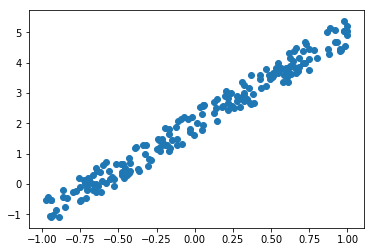

In [38]:
from bn_utils import generate_data

x_true, y_true, w_true = generate_data(size=200, shift_data=0, plot=True)

This is an animation demonstrating what the fitting does

In [4]:
from bn_utils import update_batch

def animate(i):
    update_batch(x_true, y_true, w_guess, lr=1.e-1, zero_grad=True)
    
    line.set_ydata(x_true@w_guess.detach().numpy())
    
    return line,

w_guess = nn.Parameter(tensor(-1, 1.))
fig = plt.figure()
plt.scatter(x_true[:,0], y_true, c='orange')
line, = plt.plot(x_true[:,0], x_true@w_guess.detach().numpy()) #, label=label)
plt.close()

animation.FuncAnimation(fig, animate, range(0, 100), interval=20)

## One Batch

**User's Guide Part 1**


The two main parameters of interest here are 
* `shift_data` - which shifts the `x` values and hence also `y`  
* `lr` - the learning rate.  

You will see by that by using `shift_data` you can get the loss function to explode, i.e, the activation is not stable. 

You can correct for this by lowering the learning rate.  

E.g, 

To get the results to explode set:  
`shift_data=5` (the default is `0`)  

You can then stabilise by setting 
`lr=1.e-2` (the default is `1e-1`), 

Note that this last correction stabilizes the activation but yields biased results in $a$ and $b$. 


This bias is corrected for in the [Batch Norm](#Batch-Norm) Section.  


array([6.336175, 5.264992, 4.432861, 3.771924, ..., 0.085449, 0.085449, 0.085449, 0.085449])

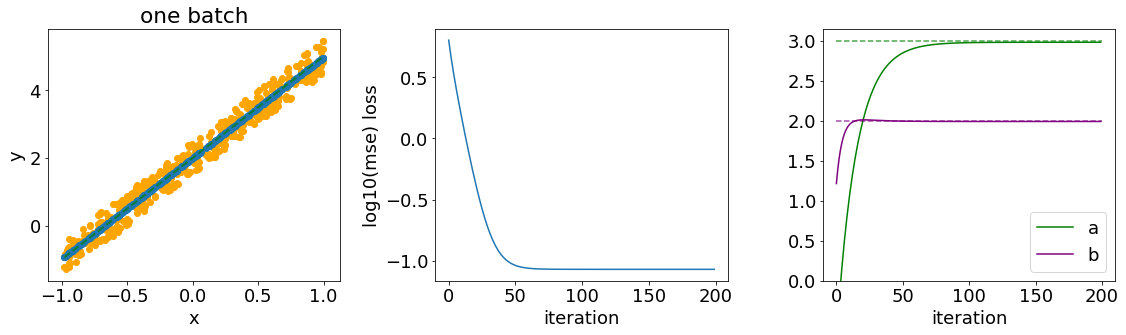

In [48]:
from bn_utils import run_batch

shift_data=0; lr=1.e-1   # works fine!
#shift_data=5; lr=1.e-1  # activation explodes!
#shift_data=5; lr=1.e-2  # learning rate stabilizes the activation but results are biassed!

run_batch(shift_data=shift_data, lr=lr)

In [41]:
from bn_utils import run_one_batch_interactive

run_one_batch_interactive()

interactive(children=(Dropdown(description='shift_data', options=(0, 1, 2, 3, 5, 10, 50), value=0), IntSlider(…

<function bn_utils.run_batch(shift_data=0, size=400, lr=0.1, iterations=200, zero_grad=True, verbose=False, plot=True)>

## Mini-Batches

**User's Guide Part 2**

Here we run a very similar algorithm, but instead of training on all the data at the same time, we run with mini-batches.

This yields similar results to one batch but the loss function is noiser due to stochasticity.



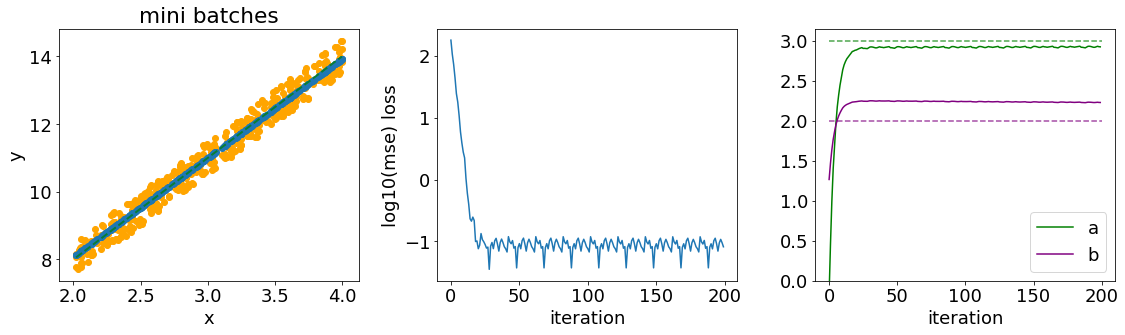

In [39]:
from bn_utils import run_batches
_ = run_batches(shift_data=3, lr=1.e-2)

In [5]:
from bn_utils import run_batches_interactive

run_batches_interactive()

interactive(children=(Dropdown(description='shift_data', options=(0, 1, 2, 3, 5, 10, 50), value=0), IntSlider(…

<function bn_utils.run_batches(shift_data=0, n_batches=20, batch_size=20, lr=0.1, iterations=200, zero_grad=True, verbose=False, plot=True)>

##  Batch Norm

**User's Guide Part 3** 

Here we use Batch norm.   

In addition to `shift_data` and `lr`,  the main parameter here `momentum`.   

We recommend using `momentum=0.9` (or `0.99`), but feel free to play around with other values!

You should see that the results (in most cases, but not all ...) are:  
* more stable
* have less bias
* learn much faster 


Play around and see for yourself!

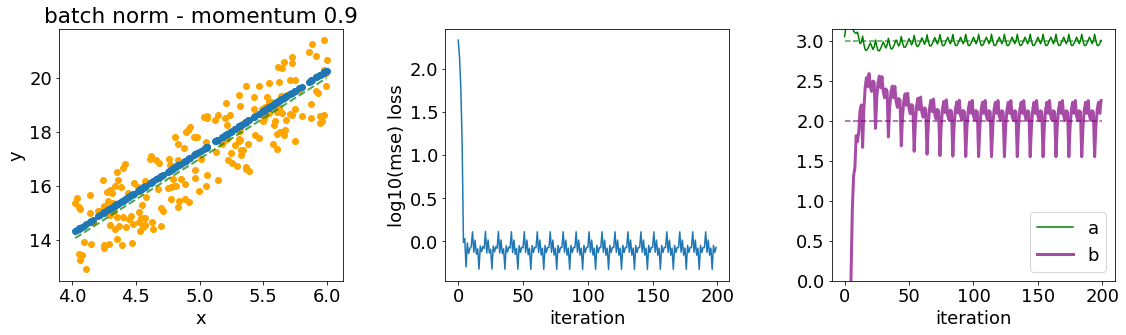

In [6]:
from bn_utils import run_batch_norm

momentum=0.9
_ = run_batch_norm(shift_data=5, momentum=momentum, lr=1.e-2, verbose=False, iterations=200)

In [9]:
from bn_utils import run_batch_norm_interactive

run_batch_norm_interactive()

interactive(children=(Dropdown(description='shift_data', options=(0, 1, 2, 3, 5, 10, 50), value=0), Dropdown(d…

<function bn_utils.run_batch_norm(shift_data=0, momentum=0.9, n_batches=10, batch_size=20, lr=0.1, iterations=100, zero_grad=True, verbose=False, epsilon=1e-07, plot=True)>

## Comparison

**User's Guide Part 4**

Comparing all the above  

* One batch
* Mini-batches 
* Batch Norm with momentum=0
* Batch Norm with non-zero momentum  

In [10]:
from bn_utils import run_comparison

run_comparison()

interactive(children=(Dropdown(description='shift_data', options=(0, 1, 2, 3, 5, 10, 50), value=0), IntSlider(…

In the following comparison we see that 
* mini batches yields similar results to the one batch and is biassed
* Both batch norm (momentum=0 and momentum=0.9) learn much faster
* Both batch norm momentum=0 yields a bias result  
* Batch norm momentum=0.9 finds the correct combination of parameters within 100 iterations. 

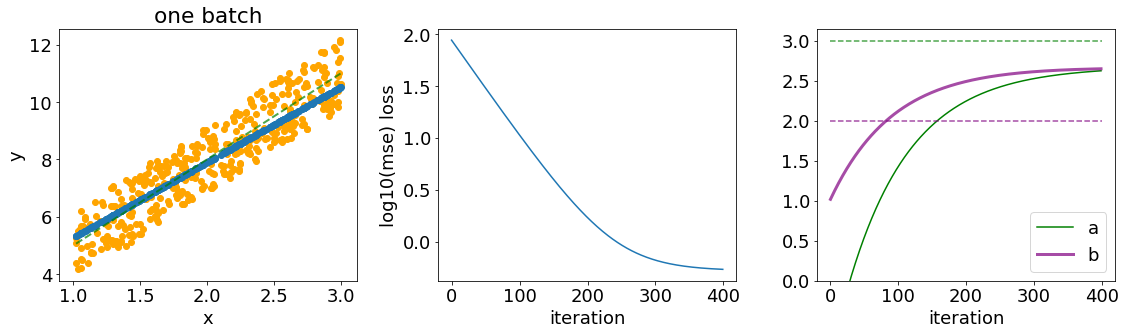

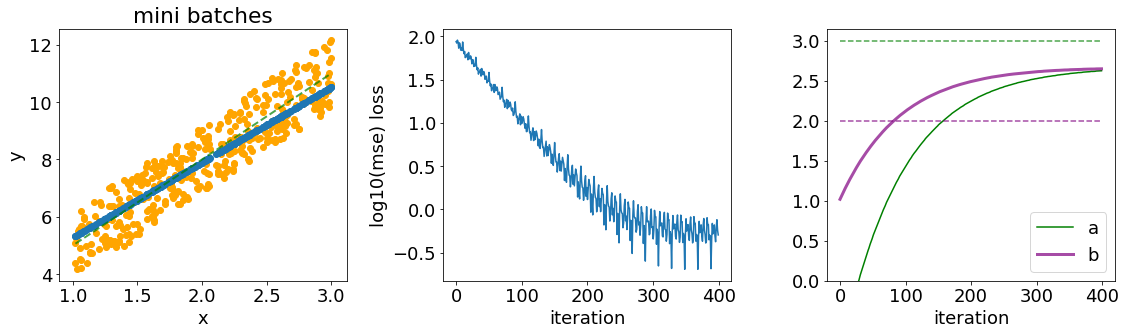

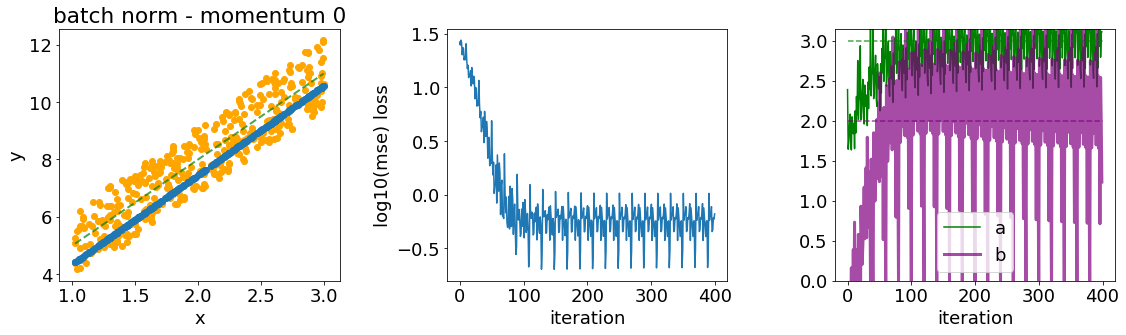

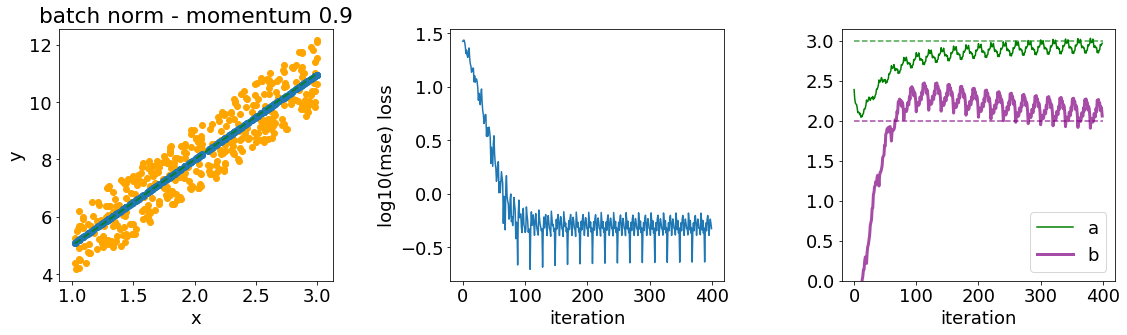

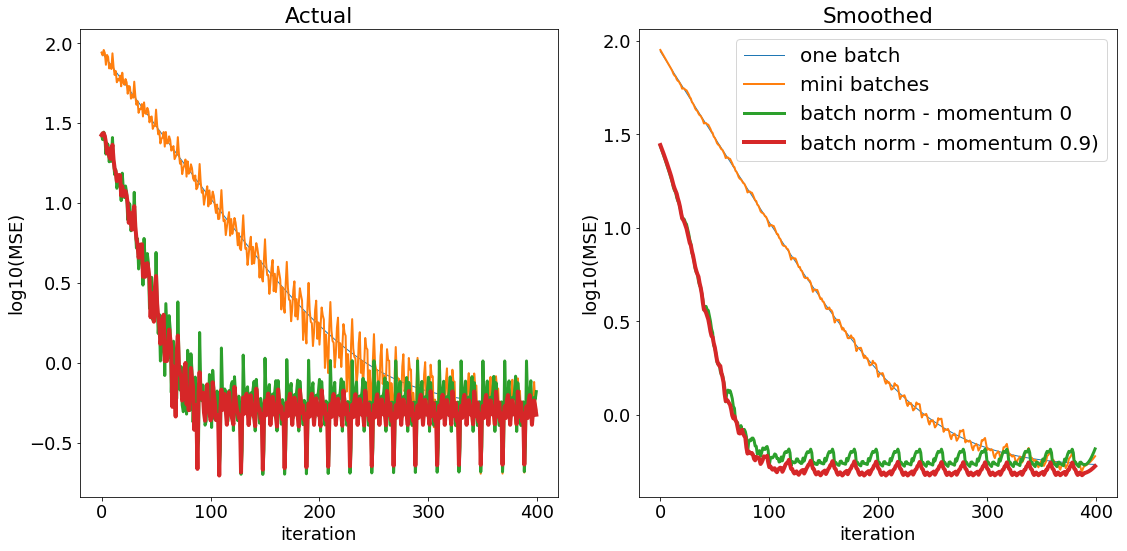

In [9]:
from bn_utils import _run_comparison
_run_comparison(shift_data=2, lr=0.001, iterations=400, plot_all=True)

## Demo Details

In the case of the non batch norm (one batch, mini batches), 
we train for a a weight parameter $\vec{w}$ according to    
6. $$\hat{y} = \vec{w}^\top\vec{x}$$ 

while minimising for the loss function 
$$
\text{MSE} = \frac{1}{m_B}\sum_{i=0}^{m_B}\left(y^{(i)} - \hat{y}^{(i)} \right)^2
$$

where $\vec{x}$ is defined as a 2D vector where $x_0$ is the data and $x_1$ is a dummy unary value (bias term).

Extracting $a$ and $b$ is straight forward:  

$a \ = \ w_0 \ \ , \ \ \ b \ = \ w_1$.

In the case of batch norm more thought is required.  
Note the first we use Equations 1-4 to calculate $\vec{z}$ and with that  

7. $$\hat{y} = \vec{w}^\top\vec{z}$$ 

and mimised $\text{MSE}$ to train $\vec{\gamma}$, $\vec{\beta}$ and $\vec{w}$ (all 2D vectors) while estimating $\mu$ and $\sigma$ (both scalars which are coupled with $x_0$ components to update $z_0$).  

Using Equations 1-4 to calculate the corresponding $\vec{z}$.  

Rearanging Equation 3-5 and relating to 7 we find:  

$$
a = w_0 \frac{\gamma_0}{\sigma}
$$

$$
b = w_0\left( \beta_0 - \frac{\gamma_0 \mu}{\sigma} \right) + w_1 \left(\beta_1 + \gamma_1 \right)
$$

or in code 
```python
a = w[0] * gamma[0] / sigma
b = w[0] * (beta[0] - gamma[0] * mu/sigma) + w[1] *(beta[1] + gamma[1])
```